# Initial exploration of DonorsChoose Dat

## 2015-05-06

Let's have a look at the projects dataset.

In [1]:
suppressMessages(library(tidyverse))

my_db <- src_postgres("donorschoose")
projects_tbl <- tbl(my_db, "projects")
 

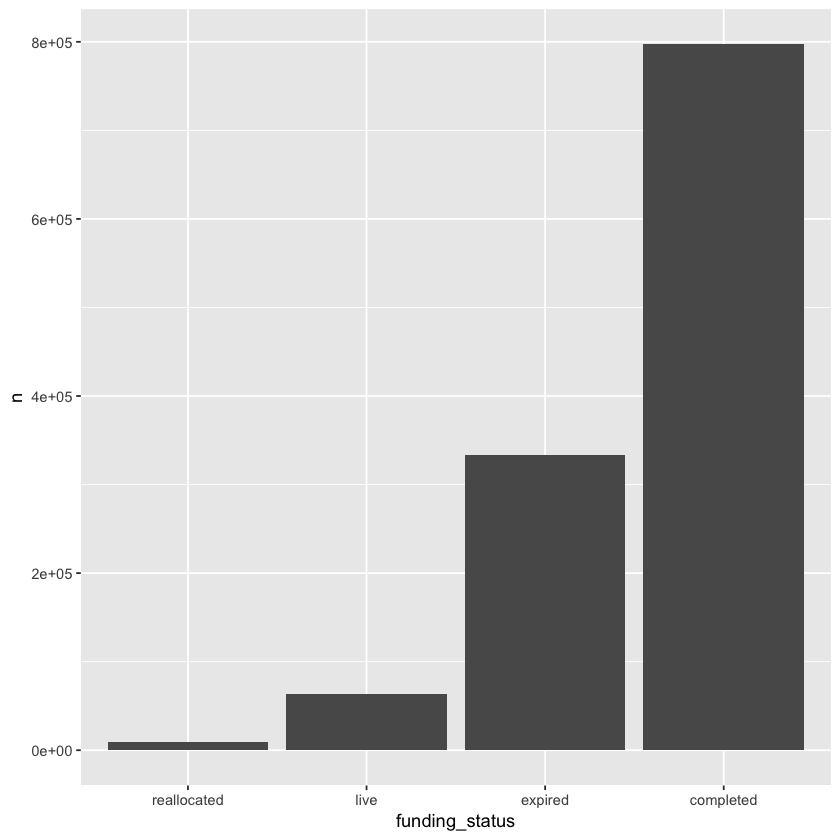

In [3]:
projects_tbl %>%
  group_by(funding_status) %>%
  count() %>%
  collect() %>% 
  mutate(funding_status = reorder(funding_status, n)) %>% 
  ggplot(aes(funding_status, n)) +
    geom_col()

Most projects are fully funded.

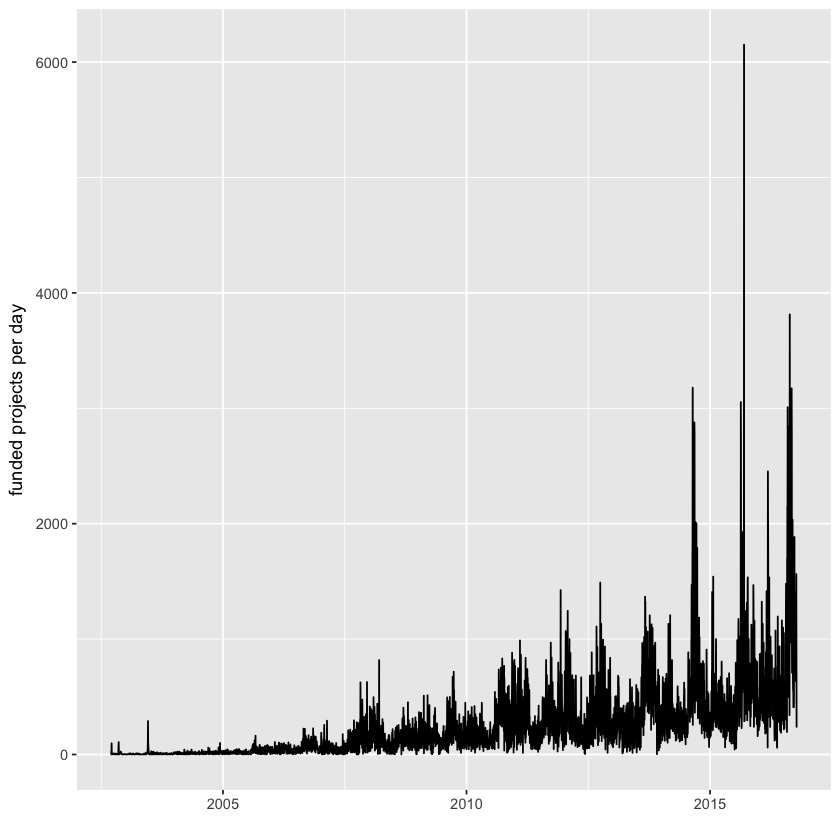

In [5]:
projects_tbl %>%
  group_by(date_posted) %>%
  count() %>%
  arrange(date_posted) %>%
  collect() %>%
  ggplot(aes(date_posted, n)) +
  geom_line() +
  labs(x = "", y = "funded projects per day") 
#  ggsave(file = "total_completed_vs_time.pdf", path = "figures/", height = 4)

Saving 7 x 4 in image


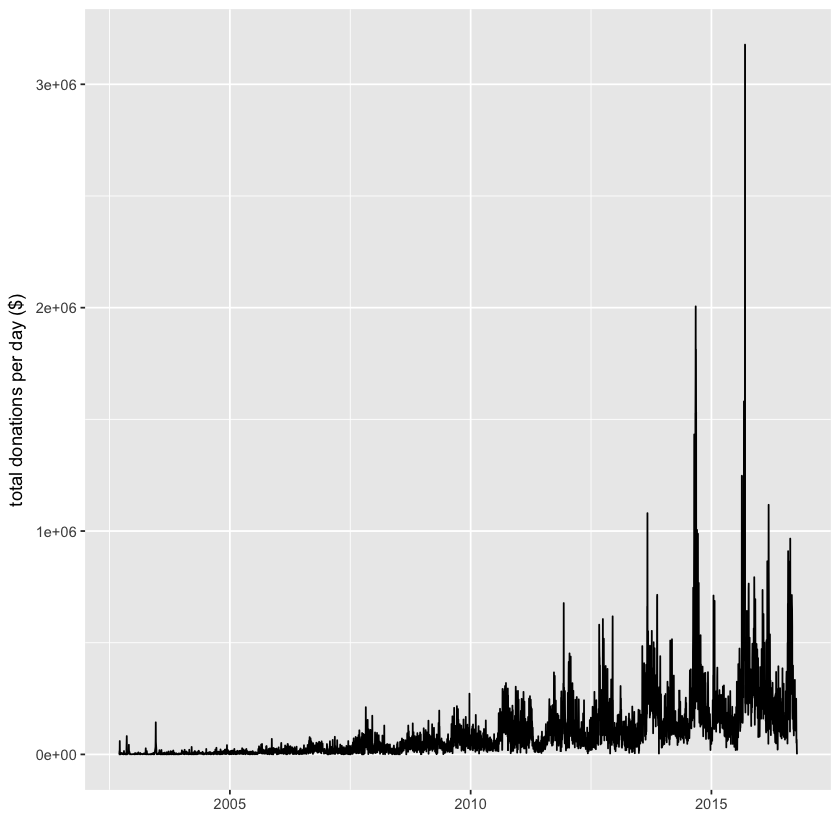

In [4]:
projects_tbl %>%
  filter(funding_status == "completed")  %>% 
  group_by(date_posted) %>%
  summarise(total_donation = sum(total_price_including_optional_support))  %>% 
  arrange(date_posted) %>%
  collect() %>%
  ggplot(aes(date_posted, total_donation)) +
  geom_line() +
  labs(x = "", y = "total donations per day ($)") 
ggsave(file = "total_donations_vs_time.png", path = "figures/", height = 4)

Posted projects increase over time, with some periodicity.

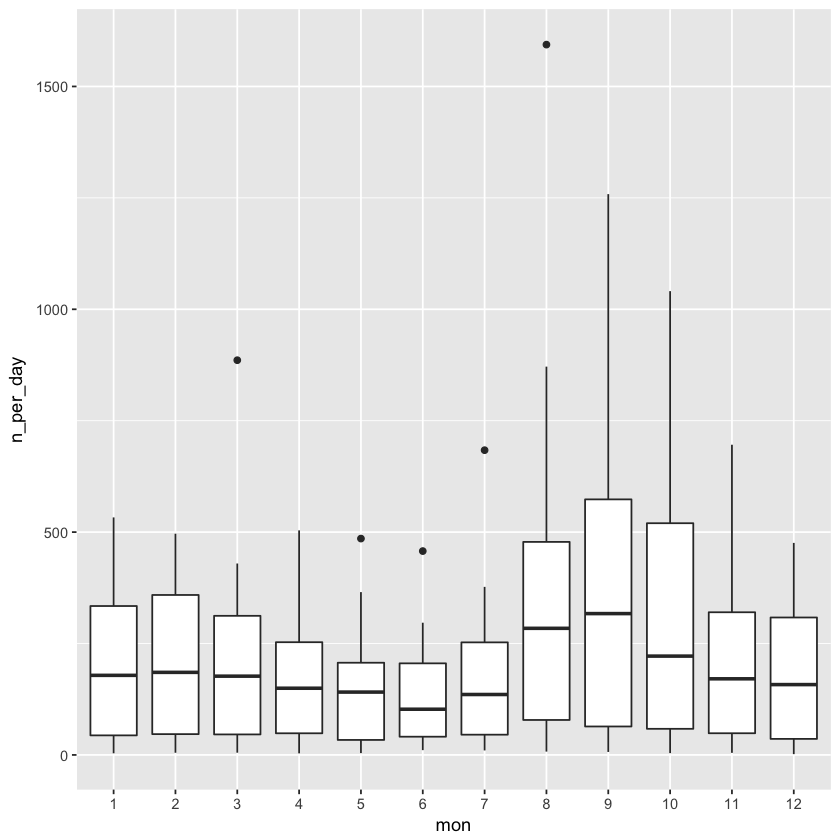

In [17]:
library(lubridate)
projects_tbl %>%
  group_by(date_posted) %>%
  count() %>%
  arrange(date_posted) %>%
  collect() %>%
  mutate(months = cut(date_posted, breaks = "month"))  %>% 
  mutate(months = as.POSIXct(months))  %>% 
  group_by(months)  %>% 
  summarise(n_per_day = mean(n))  %>% 
  mutate(mon = as.factor(month(months)))  %>% 
  ggplot(aes(mon, n_per_day)) +
  geom_boxplot()
  


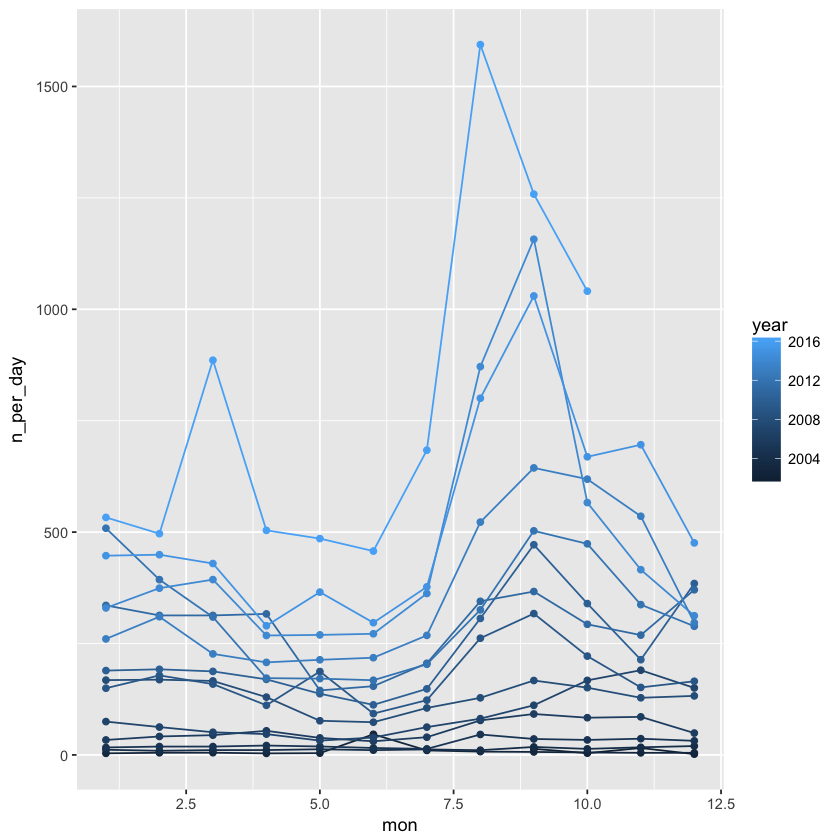

In [29]:
library(lubridate)
projects_tbl %>%
  group_by(date_posted) %>%
  count() %>%
  arrange(date_posted) %>%
  collect() %>%
  mutate(months = cut(date_posted, breaks = "month"))  %>% 
  mutate(months = as.POSIXct(months))  %>% 
  mutate(mon = as.integer(month(months)))  %>% 
  mutate(year = year(months))  %>% 
  group_by(year, mon)  %>%
  summarise(n_per_day = mean(n))  %>% 
  ggplot(aes(mon, n_per_day, group = year, color = year)) +
  geom_line() +
  geom_point()
  


We see a annual cycle with low project posting rate in the summer and high posting rate in the fall. This likely corresponds to the summer break and return to class in the fall for many schools.

In [11]:
projects_tbl %>%
  summarise(
      max_post = max(date_posted),
      max_expire = max(date_expiration)
  )  %>% 
  collect()

max_post,max_expire
2016-10-10 21:00:00,2017-12-01 21:00:00


Posted projects increase over time, with some potentially interesting periodicity.

The latest submission is on 2016-10-10 and the latest expiration date in the dataset is 2017-12-01.

In [10]:
projects_tbl  %>% 
  filter(date_expiration < "2016-10-10")  %>% 
  group_by(funding_status)  %>% 
  count()  %>% 
  collect()

funding_status,n
completed,747899
expired,320305
reallocated,9034


What are these reallocated projects?

In [13]:
projects_tbl  %>% 
  filter(funding_status == "reallocated")  %>% 
  arrange(date_posted)


Source:   query [?? x 44]
Database: postgres 9.6.3 [mcbowers@/tmp:5432/donorschoose]

# A tibble: ?? x 44
                       `_projectid`                `_teacher_acctid`
                              <chr>                            <chr>
 1 14283b6c0d40e810c55782979ad318b5 498228c64b0415ea1de4036277dac7ca
 2 396c0f1febf98c773bf5b0f48cef8750 c7384f920a4f170dd555da61dfcfa1fd
 3 2cdf0b9487ff234dcdc435cb64a37b81 dceae3d076082fc1b3bcaa69218c4b12
 4 2048807a42df4acd9ef17237d9f3bc92 7999eb31550ebf30fcccc431dc8f4b6a
 5 b392e9a275c42124136dc735bdc47169 18bf18f64dc7b02fe722c19b10582bba
 6 017be4b7013d81547408fa0e5535b998 436e37baa0fe26837e66fdbe82ec62ea
 7 5df7c4d7a9120b7f7ac19f6530f9cb24 8b5b7e4ffec0a703257cc9d0167786ae
 8 4d26bacf09f5e3b71c6b9ba45a29359d 55b2cd6c3a531c670a24c06c7d8a68d1
 9 b77bcd0f0162c005b4029b9e57ebc4fa 55b2cd6c3a531c670a24c06c7d8a68d1
10 bc001dc7e3cba2c179adbef63a094144 7877b0705bf8d9c25a4eed31f3106527
# ... with more rows, and 42 more variables: `_schoolid` <chr>,
# 

Not too sure about what's going on with the reallocated projects. Let's consider them non-complete.

## Project Posting and Completion Rates

What are the rates of posting and completion for various kinds of projects? Project dimensions include:

* primary_focus_subject
* primary_focus_area
* resource_type
* grade_level

And dimensions of the school include

* poverty_level
* school_metro

## Primary Focus Subject

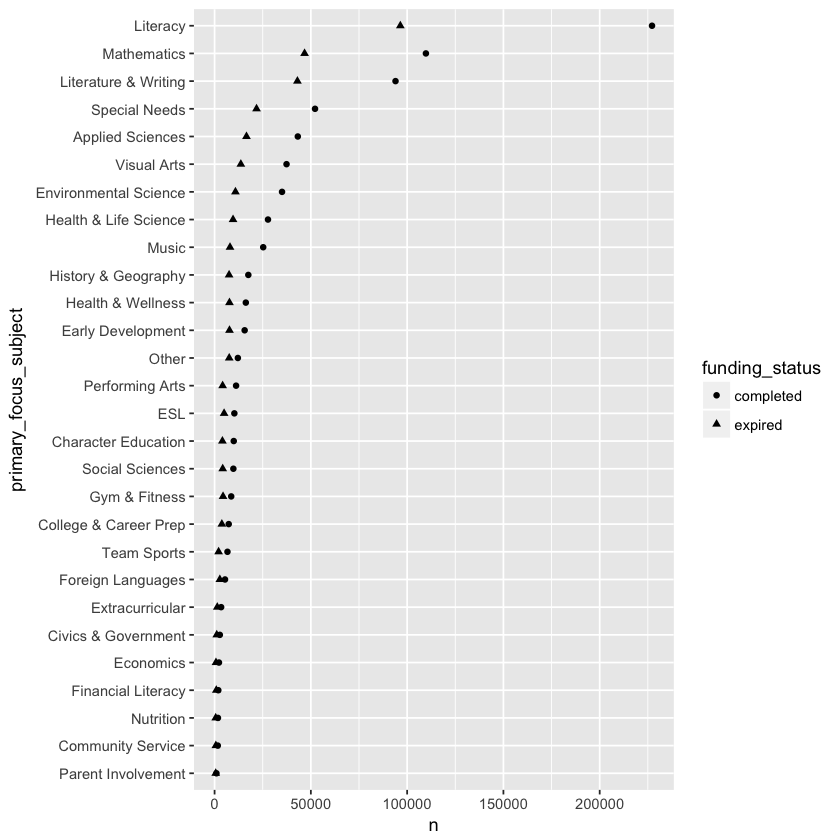

In [2]:
projects_tbl %>%
  group_by(funding_status, primary_focus_subject) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(primary_focus_subject))  %>% 
  mutate(primary_focus_subject = reorder(primary_focus_subject, n)) %>% 
  ggplot(aes(n, primary_focus_subject, shape = funding_status)) +
    geom_point()

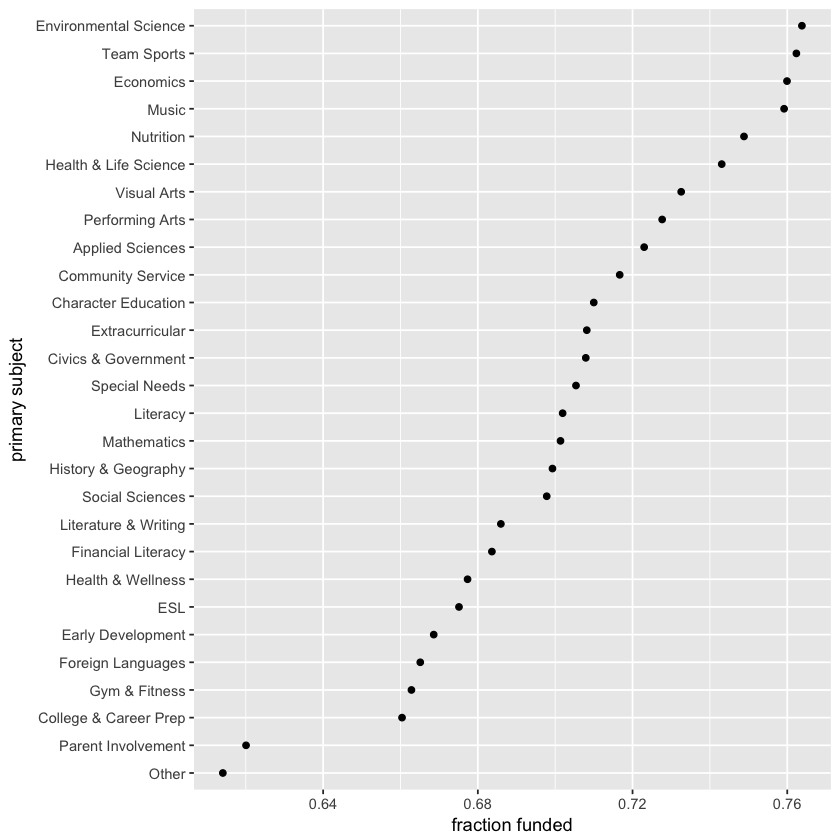

In [5]:
projects_tbl %>%
  group_by(funding_status, primary_focus_subject) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
#   mutate(primary_focus_subject = reorder(primary_focus_subject, n)) %>% 
  filter(!is.na(primary_focus_subject)) %>% 
  spread(funding_status, n) %>% 
  mutate(frac_funded = completed / (completed + expired)) %>% 
  mutate(primary_focus_subject = reorder(primary_focus_subject, frac_funded)) %>% 
  ggplot(aes(frac_funded, primary_focus_subject)) +
    labs(x = "fraction funded", y = "primary subject") +
    geom_point()
#    ggsave(file = "fraction_funded_by_subject.pdf", path = "figures")

## Primary Focus Area

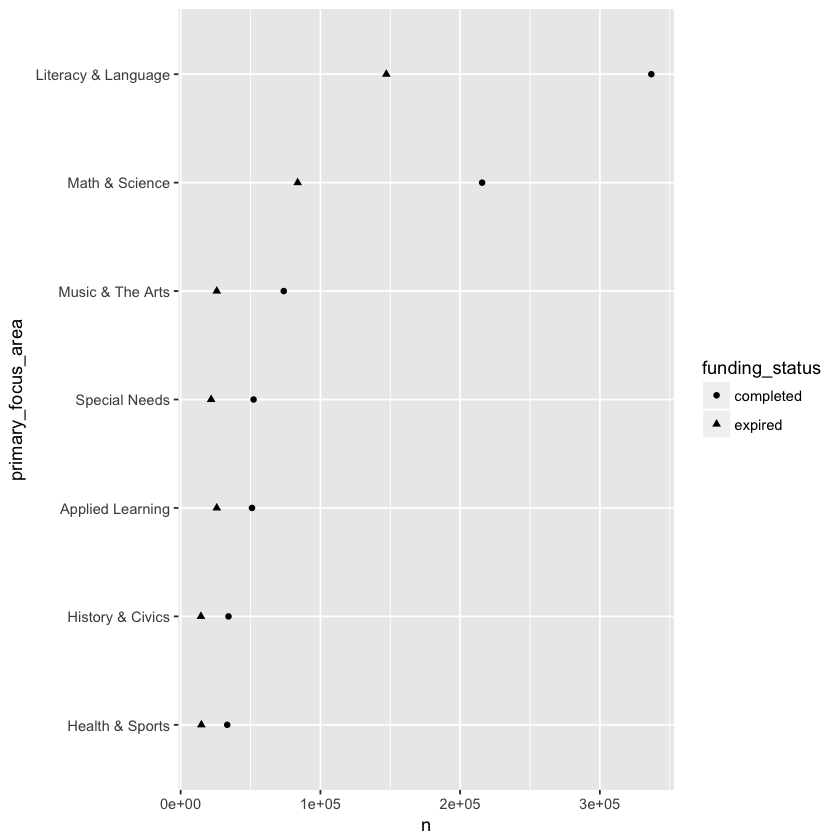

In [3]:
projects_tbl %>%
  group_by(funding_status, primary_focus_area) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(primary_focus_area))  %>% 
  mutate(primary_focus_area = reorder(primary_focus_area, n)) %>% 
  ggplot(aes(n, primary_focus_area, shape = funding_status)) +
    geom_point()

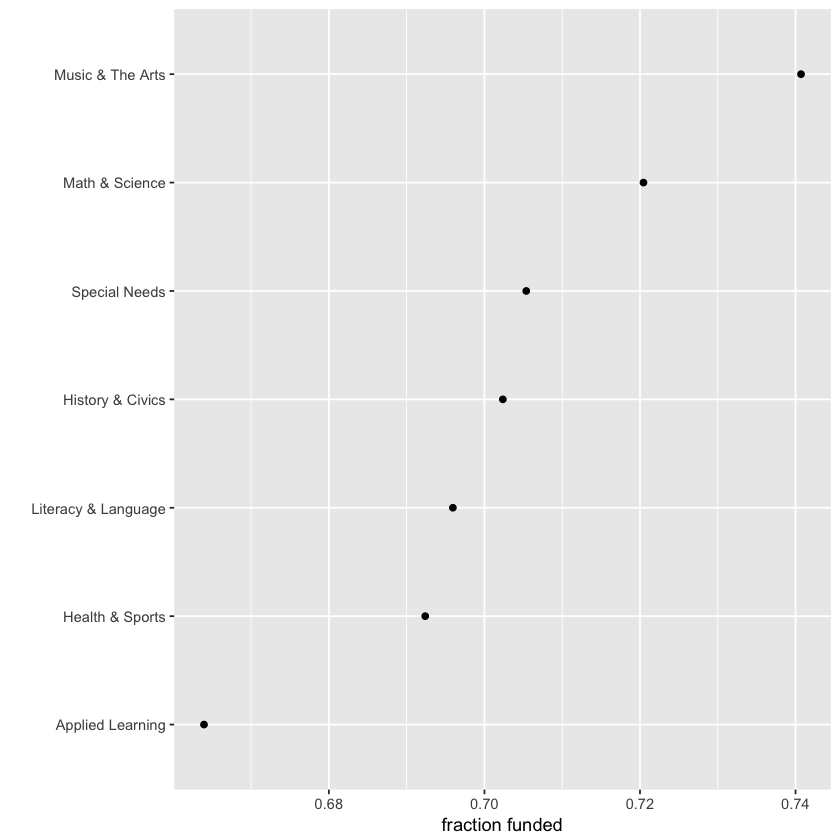

In [24]:
projects_tbl %>%
  group_by(funding_status, primary_focus_area) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(primary_focus_area)) %>% 
  spread(funding_status, n) %>% 
  mutate(frac_funded = completed / (completed + expired)) %>% 
  mutate(primary_focus_area = reorder(primary_focus_area, frac_funded)) %>% 
  ggplot(aes(frac_funded, primary_focus_area)) +
    labs(x = "fraction funded", y = "") +
    geom_point()

##  Resource Type

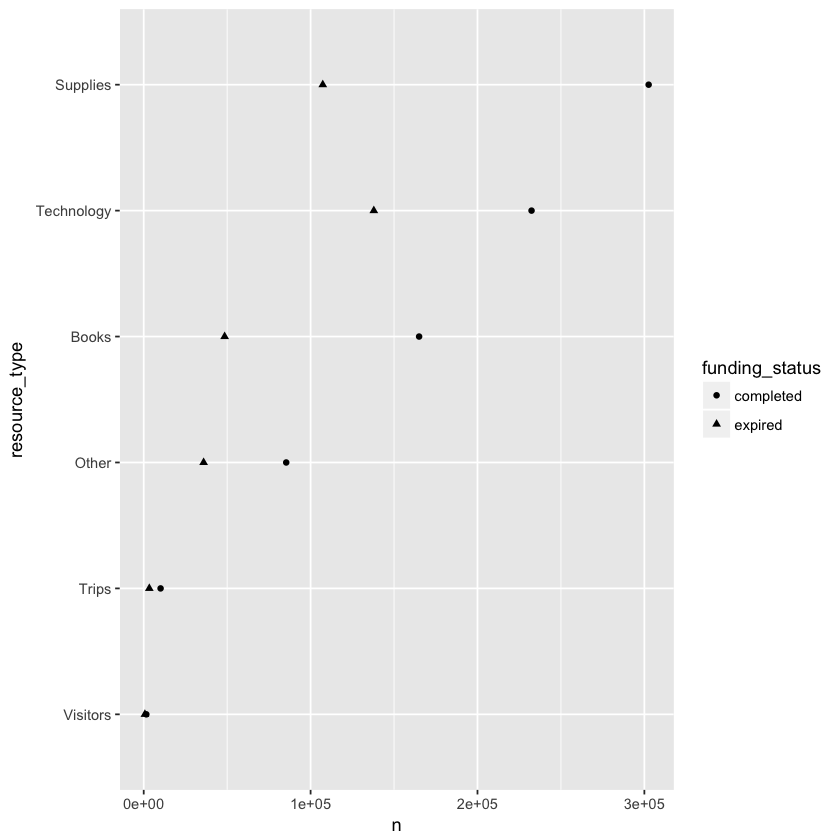

In [19]:
projects_tbl %>%
  group_by(funding_status, resource_type) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(resource_type))  %>% 
  mutate(resource_type = reorder(resource_type, n)) %>% 
  ggplot(aes(n, resource_type, shape = funding_status)) +
    geom_point() 

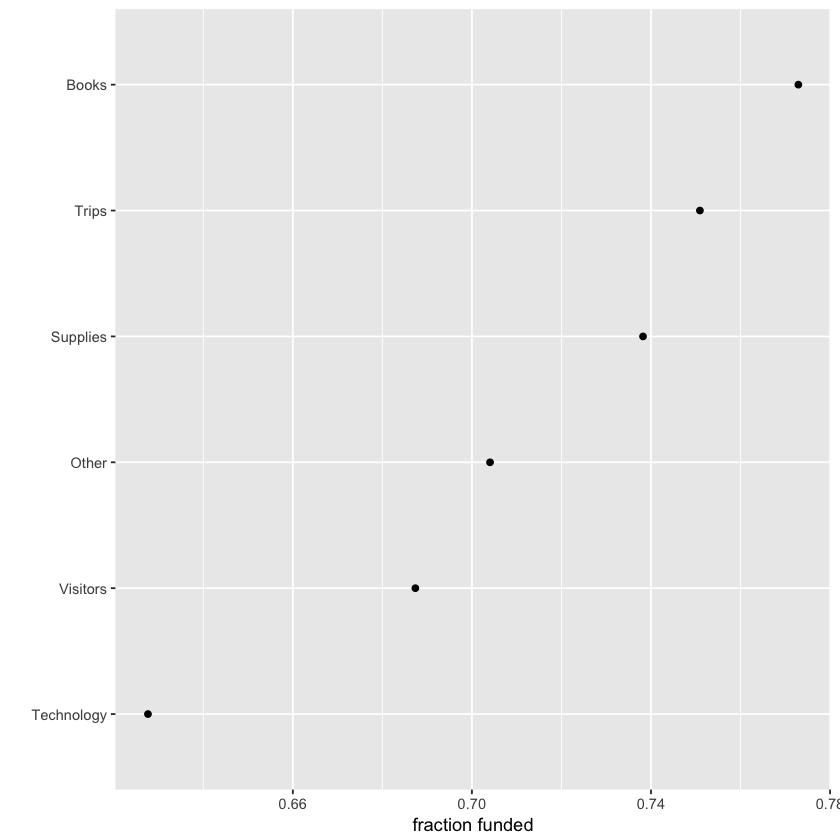

In [26]:
projects_tbl %>%
  group_by(funding_status, resource_type) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(resource_type)) %>%  
  spread(funding_status, n) %>% 
  mutate(frac_funded = completed / (completed + expired)) %>% 
  mutate(resource_type = reorder(resource_type, frac_funded)) %>% 
  ggplot(aes(frac_funded, resource_type)) +
    labs(x = "fraction funded", y = "") +
    geom_point()

## Poverty Level

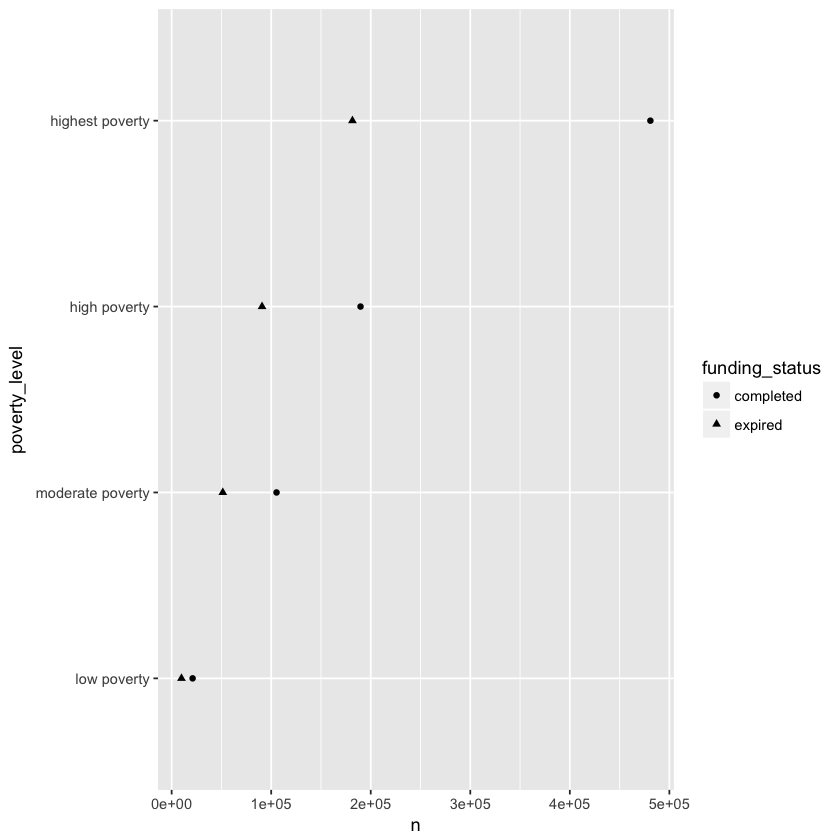

In [21]:
projects_tbl %>%
  group_by(funding_status, poverty_level) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(poverty_level))  %>% 
  mutate(poverty_level = reorder(poverty_level, n)) %>% 
  ggplot(aes(n, poverty_level, shape = funding_status)) +
    geom_point() 

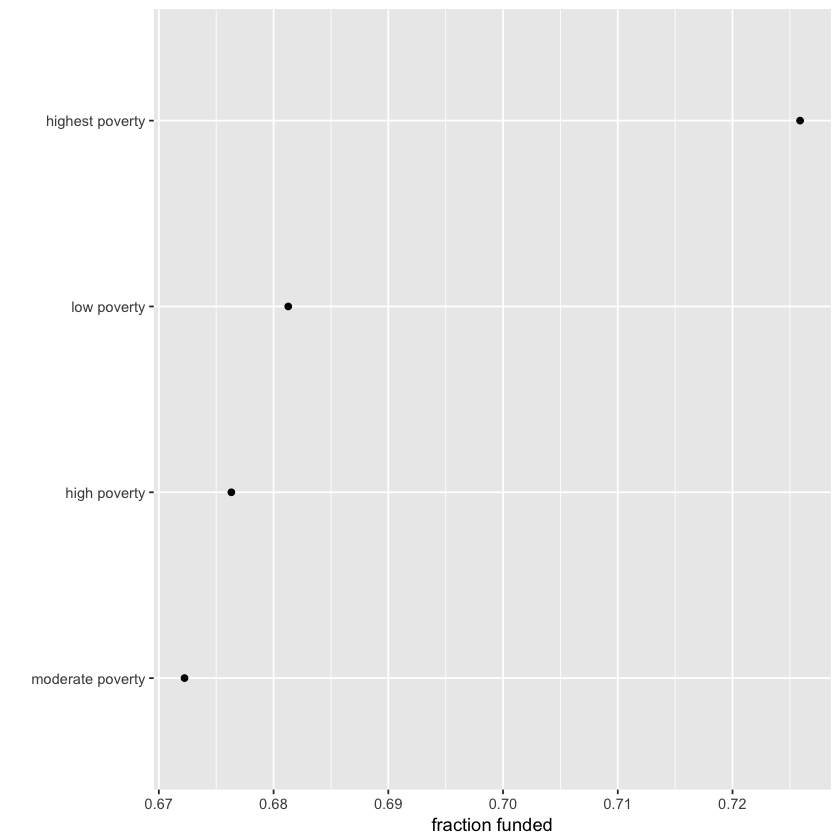

In [27]:
projects_tbl %>%
  group_by(funding_status, poverty_level) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(poverty_level)) %>%  
  spread(funding_status, n) %>% 
  mutate(frac_funded = completed / (completed + expired)) %>% 
  mutate(poverty_level = reorder(poverty_level, frac_funded)) %>% 
  ggplot(aes(frac_funded, poverty_level)) +
    labs(x = "fraction funded", y = "") +
    geom_point()

## School Metro

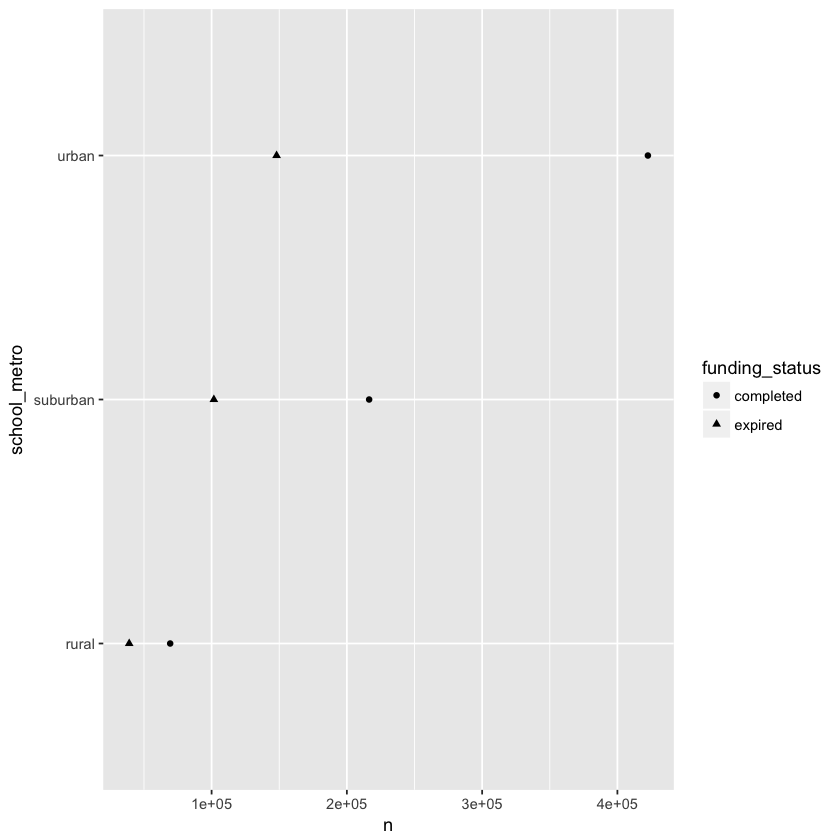

In [22]:
projects_tbl %>%
  group_by(funding_status, school_metro) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(school_metro))  %>%  
  mutate(school_metro = reorder(school_metro, n)) %>% 
  ggplot(aes(n, school_metro, shape = funding_status)) +
    geom_point() 

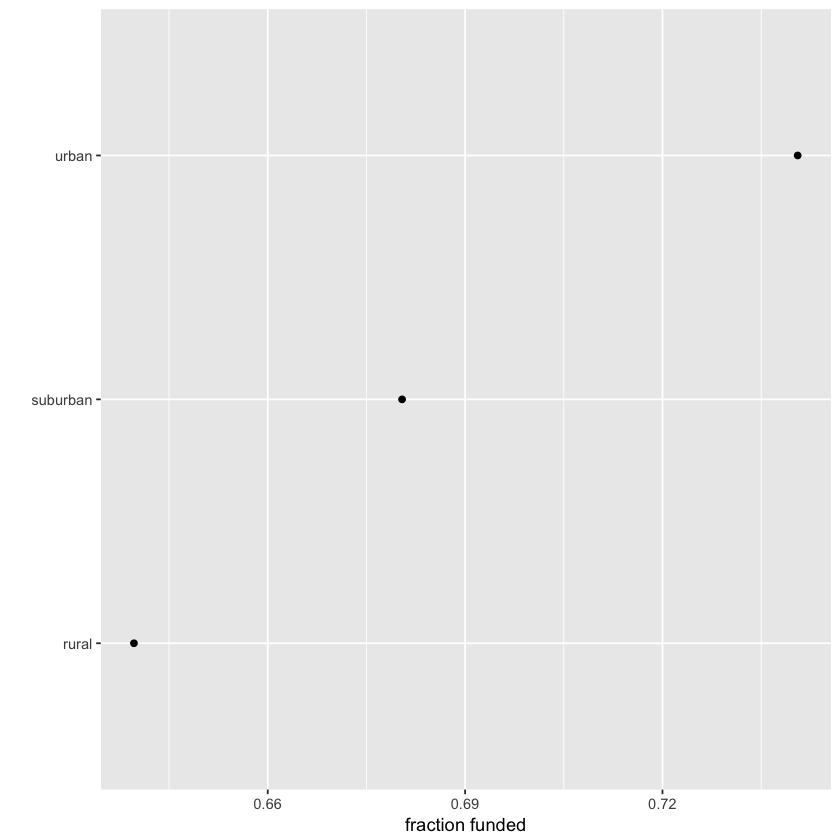

In [29]:
projects_tbl %>%
  group_by(funding_status, school_metro) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(school_metro)) %>%   
  spread(funding_status, n) %>% 
  mutate(frac_funded = completed / (completed + expired)) %>% 
  mutate(school_metro = reorder(school_metro, frac_funded)) %>% 
  ggplot(aes(frac_funded, school_metro)) +
    labs(x = "fraction funded", y = "") +
    geom_point()
                

## Grade Level

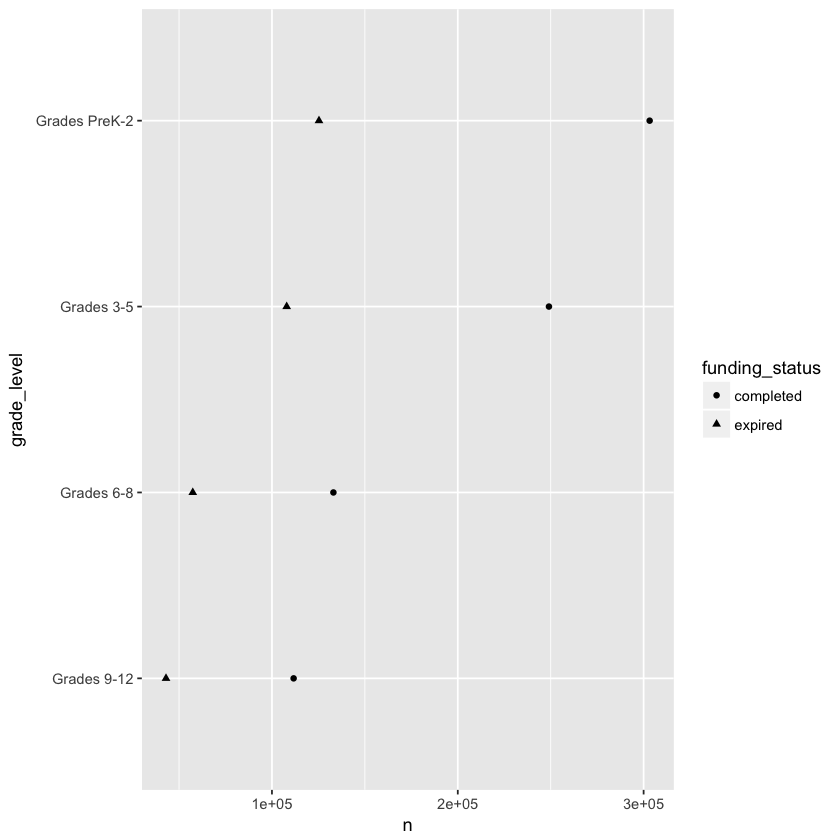

In [23]:
projects_tbl %>%
  group_by(funding_status, grade_level) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count(c) %>%
  collect() %>% 
  filter(!is.na(grade_level))  %>%   
  mutate(grade_level = reorder(grade_level, n)) %>% 
  ggplot(aes(n, grade_level, shape = funding_status)) +
    geom_point() 

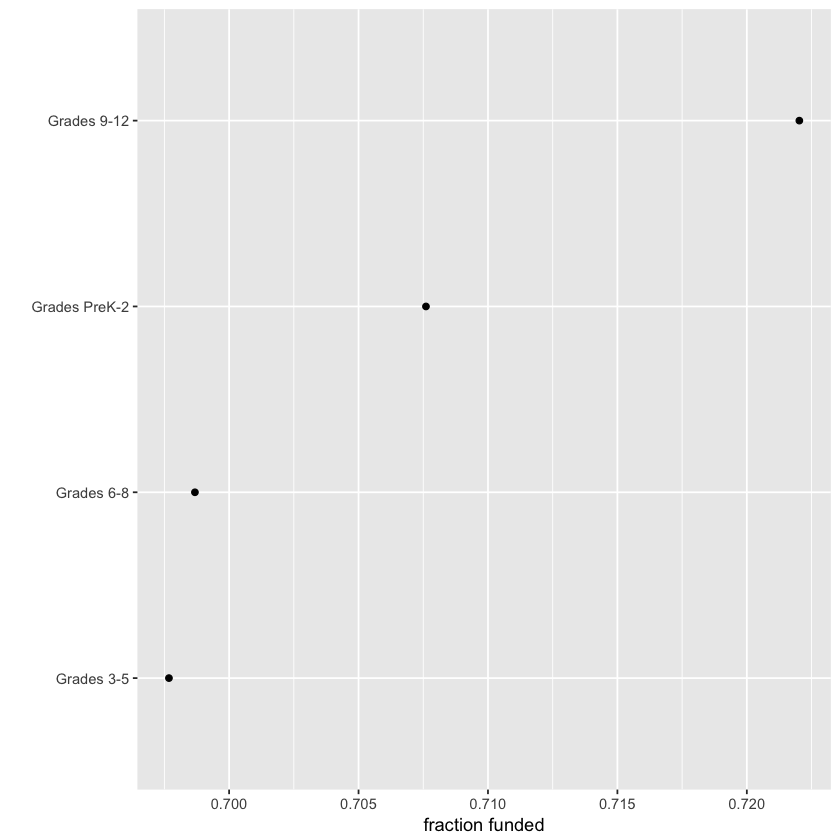

In [31]:
projects_tbl %>%
  group_by(funding_status, grade_level) %>%
  filter(funding_status %in% c("completed", "expired")) %>% 
  count() %>%
  collect() %>% 
  filter(!is.na(grade_level)) %>%    
  spread(funding_status, n) %>% 
  mutate(frac_funded = completed / (completed + expired)) %>% 
  mutate(grade_level = reorder(grade_level, frac_funded)) %>% 
  ggplot(aes(frac_funded, grade_level)) +
    labs(x = "fraction funded", y = "") +
    geom_point()
              

## Try to make a functional pipeline

In [ ]:
get_completion_rates <- function(pg_tb, x){
  pg_tb %>%
  group_by_(quote(funding_status), x) %>%
  count()  %>% 
  collect()  %>% 
  spread(funding_status, n)  %>% 
  mutate(
    n_proposed = completed + expired, 
    n_funded = completed,
    rate_funded = completed / (completed + expired)
  )  %>% 
  select_(x, quote(n_proposed), quote(n_funded), quote(rate_funded)) 
}

In [ ]:
rate_plot <- function(df, x_str, y_str){
    dots = list()
    ggplot(df, aes_string(x = x_str, y = y_str)) +
    geom_point()
}

In [ ]:
my_var <- "poverty_level"

get_completion_rates(projects_tbl, my_var)  %>% 
  mutate(grade_level = reorder(grade_level, rate_funded))  %>% 
  filter(!is.na(grade_level))  %>% 
  rate_plot("rate_funded", my_var)